The goal of this workbook is to try out some PCA to reduce the number of dimensions among our potential predictor variables.

In particular, there are several collections of physical measurements that seem like they might have a latent variable. Perhaps we can use PCA to reduce each category of physical measurement to a small number (1-3) dimensions that will be easier to incorporate into a predictive model

First, I'll try a regular PCA with the physical variables to see if it's possible/meaningful.

Then I'll try it with the FitnessGram variables and the Bio-electric Impedance variables

**Some Big Questions**

* If one variable is dependent on others, should we include it? In this case, we have height, weight, and BMI as variables. BMI is computed from the first two (it's weight divided by the squarae of height). Does this mean if we include all three variables that, in some way, height and weight will be over-weighted because they're sort of being counted twice? Or does the fact that BMI uses the inverse of the square of height mean that we should still include it?
* If two variables are directly related, should we include both of them? In our data we have weight and waist circumference. I'm pretty sure we've explored how/that these are directly proportional. Does that mean we should only use one of them in the PCA? And/or in the model? (Similar question for systolic and diastolic blood pressure.)
* PCA "can only be used with linear data." I'm  wondering what "only be used with linear data" means. "Linear" refers to a relationship between variables. So how would we identify whether or not PCA can be used?

**Some Ideas about Answers**

* The whole point of PCA is reducing the number of variables when they are dependent on each other. If two variables are perfectly correlated, then PCA will reduce them to a single dimension.
* "Can only be used with linear data" means that if two variables have a distinctly non-linear relationship then you either need to transform one of the variables (to make the relationship linear) or use an alternative method - like kernel PCA - that doesn't rely on assumptions of linearity

**More Questions**
* I believe we can do PCA on subsets of the variables and then recombine them to make new predictors that we can use in the final model. How exactly does this process work?
* What benefits and drawbacks are there to selecting the sets on which we do PCA versus trying to use PCA for all of the predictor variables?
* How do we handle missing values?

In [1]:
# Start by loading the necessary packages
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# Load the (split) data set train_imp.csv
train = pd.read_csv('train_imp.csv')

# We'll first explor the "Physical" variables. 
# One variable is "Season of Participation" which we'll exclude from this PCA

# Make a list of all variables that start with 'Physical' and are type float or int
physical_vars = [col for col in train.columns if col.startswith('Physical') and train[col].dtype in ['float64', 'int64']]

train_physical = train[physical_vars]

We should take a look at/for missing values before proceeding. If one of the variables has a lot of missing values, we should either impute them or drop the variable. If several variables have missing values from the same participants, then we should either impute them or derop the participants.

In [3]:
# Count the number of NaN values for each variable
print(train_physical.isna().sum())

Physical-BMI                     155
Physical-Height                  153
Physical-Weight                  121
Physical-Waist_Circumference    1813
Physical-Diastolic_BP            197
Physical-HeartRate               189
Physical-Systolic_BP             197
dtype: int64


Waist_Circumference has a *lot* of missing values, so we should drop it from our analysis.

For the others, we should see if the missing values come from the same participants

In [5]:
# Remove the Physical-Waist_Circumference variable from train_reduced
train_physical = train_physical.drop(columns=['Physical-Waist_Circumference'])

NaNs
0    1978
6     118
5      34
3      32
2      16
1       6
Name: count, dtype: int64


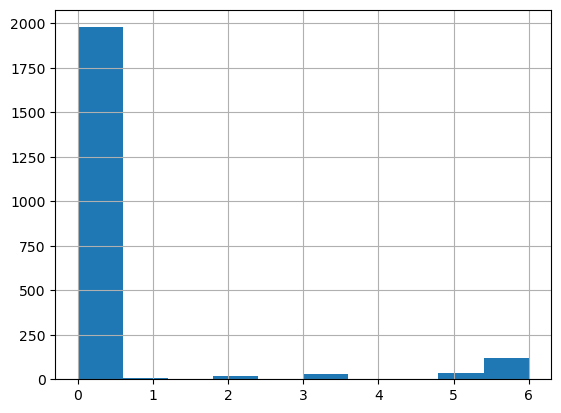

In [7]:
# Count the number of NaN values for each row in train_reduced.
train_physical['NaNs'] = train_physical.isna().sum(axis=1)

#Make a histogram of the distribution of these counts
train_physical['NaNs'].hist()

# Make a table of the distribution of train_reduced['NaNs']
print(train_physical['NaNs'].value_counts())

It looks like most of the NaN values are coming from participants with little or no Physical data: 118 participants didn't have any Physical values and another 34 only had one. 

This leaves 54 participants (out of the remaining 1978) who had 1, 2, or 3 missing values. 

There *are* PCA algorithms that try to estimate missing values. Here is an article about some options in R:
https://medium.com/@seb231/principal-component-analysis-with-missing-data-9e28f440ce93

It seems like the safest thing to do here is to remove all of these participants from the data set (for now) rather than trying to impute values, since the imputation would likely rely on the values we're trying to use to generate the PCA analysis.

In [8]:
# Remove all rows that contain one or more NaN values from train_reduced
train_physical = train_physical.dropna()

# Remove the NaNs variable from train_reduced
train_physical = train_physical.drop(columns=['NaNs'])

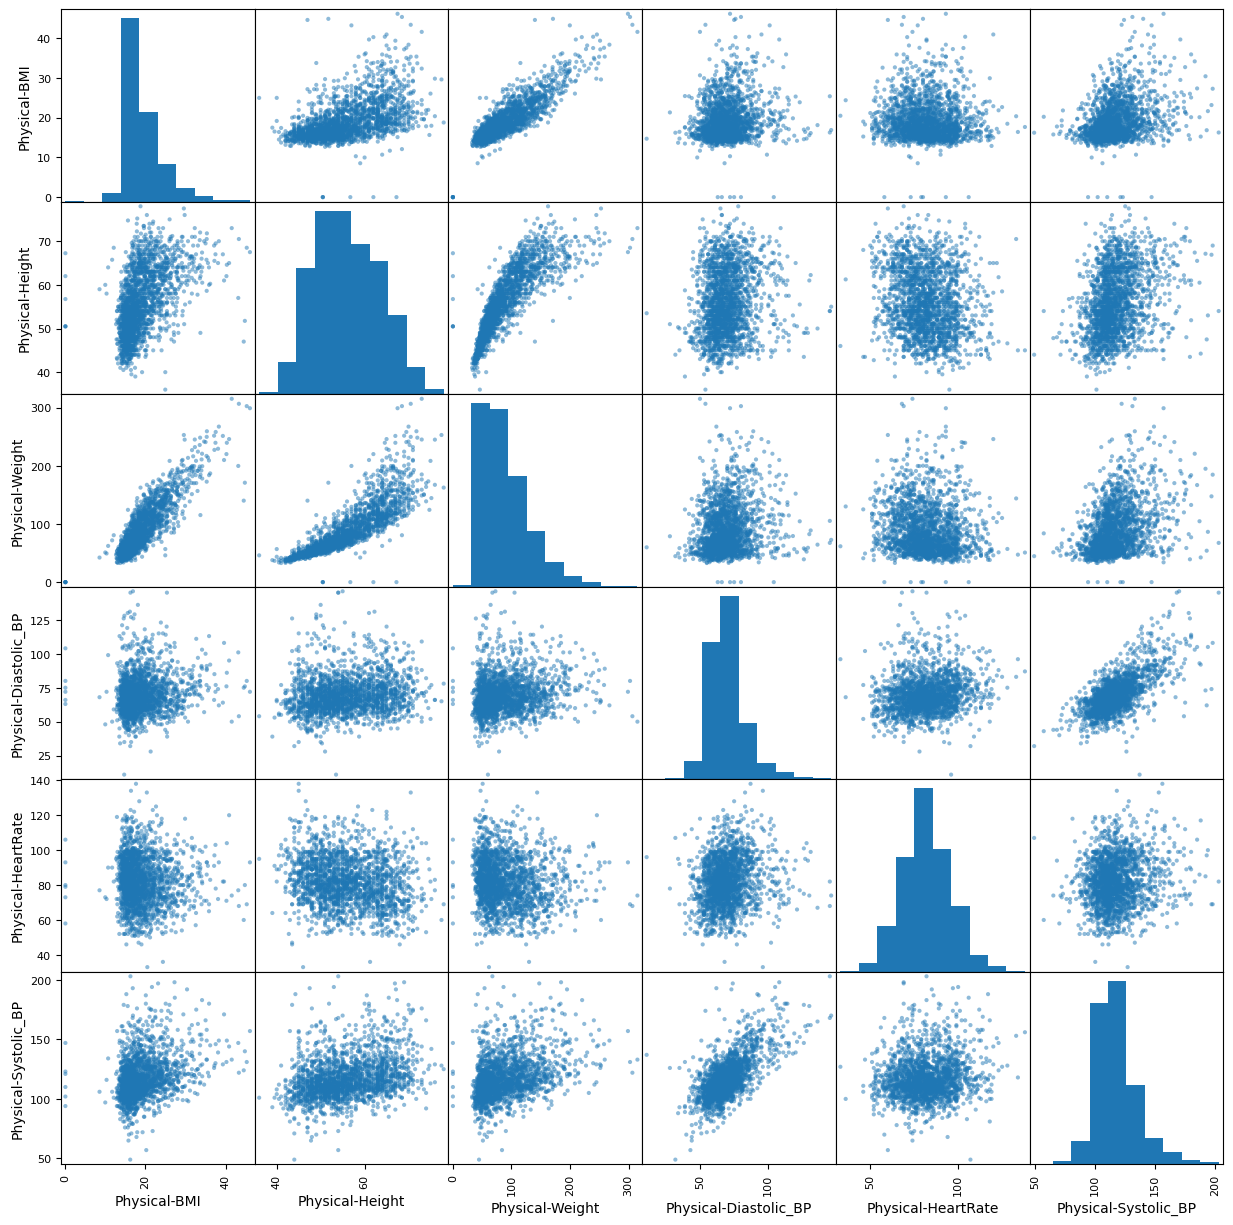

In [9]:
# PCA can only be used with linear data. So let's examine relationships between these five variables
from pandas.plotting import scatter_matrix
scatter_matrix(train_physical, figsize=(15,15))
plt.show()

**There are some clear linear associations here.**

The following variables appear to be linearly associated:
<ul>
<li>*BMI and Weight
<li>*Diastolic_BP and Systolic_BP
</ul>

When I looked at this previously, I found a couple of associations with Waist_Circumference (which we dropped from the data):
<ul>
<li>*BMI and Waist_Circumference
<li>*Height and Waist_Circumference
<li>*Weight and Waist_Circumference
<li>*Waist_Circumference and Systolic_BP
</ul>

The following variables appear to be associated in some non-linear way
<ul>
<li>*BMI and Height (as height increases, BMI increases... quadratically? exponentially?)
<li>*Height and Weight (as height increases, Weight increases... quadratically? exponentially?)
</ul>

We can also look at a correlation matrix between these variables

In [10]:
# Create a correlation matrix of the variables in physical_vars
train_physical.corr()

,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP
Physical-BMI,1.000000,0.501320,0.875229,0.146883,-0.033187,0.325791
Physical-Height,0.501320,1.000000,0.834289,0.131355,-0.182951,0.311533
Physical-Weight,0.875229,0.834289,1.000000,0.153962,-0.110546,0.365724
Physical-Diastolic_BP,0.146883,0.131355,0.153962,1.000000,0.157856,0.674454
Physical-HeartRate,-0.033187,-0.182951,-0.110546,0.157856,1.000000,0.128591
Physical-Systolic_BP,0.325791,0.311533,0.365724,0.674454,0.128591,1.000000


Each column has at least one large-ish value, with the exception of HeartRate, so these data are a good candidate for PCA.

BUT! Some of the relationships are (slightly?) non-linear, so maybe we should be using Kernel PCA instead of regular PCA?

Just to get some practice, I'll proceed with regular PCA first. I'll be following the steps and explanation on https://medium.com/analytics-vidhya/dimensionality-reduction-principal-component-analysis-d1402b58feb1

In [11]:
# Instantiate a new PCA object
pca_physical = PCA()

# PCA requires data to be centered at 0, so we need to first scale the data
X_Scaled = StandardScaler().fit_transform(train_physical)

# Then we'll fit and transform the data
principalComponents_Physical = pca_physical.fit_transform(X_Scaled)

In [12]:
# Examine the principal components
principalComponents_Physical = pd.DataFrame(principalComponents_Physical)
print(principalComponents_Physical.shape)
principalComponents_Physical.head(5)

(1978, 6)


,0,1,2,3,4,5
0,0.485194,0.942511,-0.839533,-0.576339,-0.025934,-0.096343
1,-1.611138,-0.981086,-0.488815,0.271603,-0.690417,0.022557
2,3.889578,-1.750536,-0.127250,-1.007233,-0.318160,0.254139
3,-0.481381,-1.389346,1.826290,0.008178,-0.648758,-0.128239
4,-1.489506,-0.726066,-0.984021,-0.216631,-0.005558,0.051038


We get 6 principal components (which is equal to the number of predictors). The first principal component (0) gives the direction of maximum variance.

The eigenvalues of the covariance matrix explain the maximum variance. The first eigenvalue explains maximum variance

In [13]:
# List the eigenvalues for the covariance matrix of train_reduced
pca_physical.explained_variance_

array([2.81532446, 1.51791301, 0.88283072, 0.47476528, 0.29718792,
       0.01501353])

Next, we can look at how much percentage of variance is explained by each principal component and the number of components we need to retain maximum variance from our original data.

In [14]:
# Compute pca.explained_variance_ratio_
pca_physical.explained_variance_ratio_

array([0.46898352, 0.2528576 , 0.14706407, 0.07908754, 0.04950628,
       0.00250099])

So:
<ul>
<li> The first principal component explains 47% of the variance
<li> The second principal component explains 25% of the variance
<li> The third principal component explains 15% of the variance
<li> The fourth principal component explains 8% of the variance
<li> The fifth principal component explains 5% of the variance
<li> The sixth principal component explains 0.3% of the variance
</ul>

This means that we could explain 72% of the total variance with the first two components, and 87% of the total variance with the first three.

So it seems like we can use three of these components rather than all six...?

Next, we need to understand which variables from the original data influenced these principal components the most.

In [15]:
# Create a data frame of the principal components
pc_df_physical = pd.DataFrame(abs(pca_physical.components_[:3]), columns=train_physical.columns, index=['Principal component 1','Principal component 2','Principal component 3'])

pc_df_physical

,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP
Principal component 1,0.492905,0.481685,0.560056,0.258992,0.042434,0.377470
Principal component 2,0.168750,0.243935,0.235130,0.621496,0.462945,0.506120
Principal component 3,0.283944,0.045017,0.161554,0.326271,0.854674,0.233088


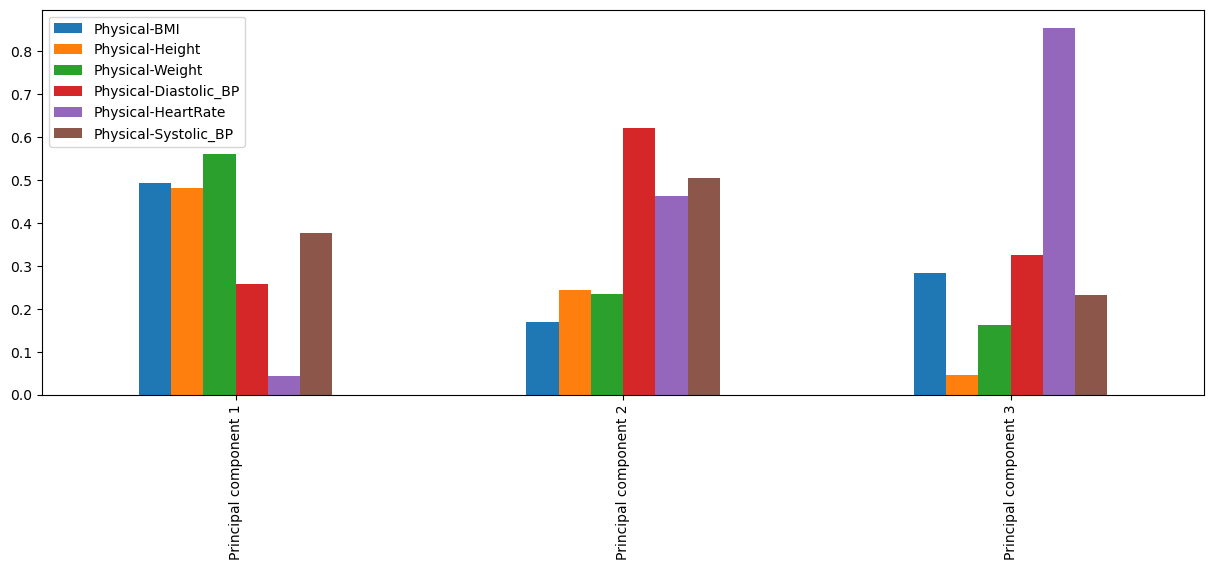

In [16]:
# Make a bargraph for each index in pc_df
pc_df_physical.plot(kind='bar', figsize=(15,5))
plt.show()

This graph suggests that there are three basic components:
<ul>
<li> How "big" you are (Height-weight-BMI)
<li> Your blood pressure (Diastolic & Systolic BP, and a bit of heart rate)
<li> Heart rate
</ul>

I'm going to try adding a couple of more complicated graphs. These will likely be more difficult to interpret.

KeyError: (slice(None, None, None), 0)

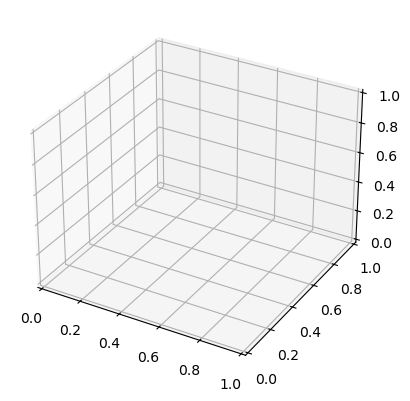

In [18]:
# Make a 3D graph
# This syntax suggested by the AI in my Brave search engine... :)

# Prepare 3D plotting environment
fig = plt.figure()
ax = plt.axes(projection='3d')

# Plot 3D PCA scatterplot
xdata = principalComponents_Physical[:, 0]
ydata = principalComponents_Physical[:, 1]
zdata = principalComponents_Physical[:, 2]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='viridis')

# Customize plot
plt.title('3D Scatter of Physical Components')
ticks = np.linspace(-3, 3, num=5)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_zticks(ticks)
ax.set_xlabel('Component 0?', rotation=150)
ax.set_ylabel('Component 1?')
ax.set_zlabel('Component 2?', rotation=60)
plt.show()


In [20]:
# Visualize the loadings
# (From https://plotly.com/python/pca-visualization/)

import plotly.express as px

#df = px.data.iris()
#features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
#X = df[features]

#pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(X)

loadings = pca_physical.components_.T * np.sqrt(pca_physical.explained_variance_)

fig = px.scatter(principalComponents_Physical, x=0, y=1)

for i, feature in enumerate(train_physical.columns):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )
fig.show()

Next, let's look at the FitnessGram quantitative variables:

*FGC-FGC_CU
*FGC-FGC_GSND
*FGC-FGC_GSD
*FGC-FGC_PU
*FGC-FGC_SRL
*FGC-FGC_SRR
*FGC-FGC_TL

The other FitnessGram variables are categorical; it seems like we could scale and sum them to get a single overall measure of fitness?